# **Predictive Maintenance for Agricultural Tractors**
# Audio Anomaly Detection using MIMII + Freesound Tractor Data

# **PART 1: Model Training & Comparison**

**Objective:**  
Train multiple ML/DL models on the **MIMII pump dataset** to detect industrial anomalies from sound.

**Models to Compare:**  
| Type | Model |
|------|-------|
| Traditional ML | KNN, Isolation Forest, SVM |
| Deep Learning | CNN, VGG-like CNN, **ResNet-like CNN** |

**Goal:**  
- Extract MFCC features  
- Train all models  
- Compare using **F1-score, AUC-ROC, PR-AUC**  
- **Select best model** → proceed to transfer learning

**Why MIMII?**  
- Publically available, labeled, industrial sound dataset  
- Ideal for baseline training before tractor adaptation

# Imports & Setup

In [2]:
# --------------------------------------------------------------
# 1. Imports & Global Setup
# --------------------------------------------------------------
import os, json, random, time, warnings
from pathlib import Path
from tqdm import tqdm

import numpy as np, pandas as pd
import matplotlib.pyplot as plt, seaborn as sns

import librosa
from pydub import AudioSegment

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import IsolationForest
from sklearn.svm import SVC
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             classification_report, confusion_matrix,
                             roc_auc_score, average_precision_score)
from sklearn.utils import resample

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, Dense, Flatten, Dropout,
                                     BatchNormalization, GlobalAveragePooling2D, Input, Add, ReLU)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau # Added ReduceLROnPlateau
import joblib

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Reproducibility
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

c:\Users\jishi\OneDrive\Desktop\tractorcare\.venv\Lib\site-packages\pydub\utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


# Config Class

In [3]:
# --------------------------------------------------------------
# 2. Configuration
# --------------------------------------------------------------
class Config:
    def __init__(self, environment='colab'):
        self.environment = environment
        self.sample_rate = 16000
        self.duration = 10
        self.n_mfcc = 40
        self.max_len = 100
        self.test_size = 0.2
        self.validation_split = 0.2
        self.random_state = 42
        self.epochs = 20
        self.batch_size = 32
        self.early_stopping_patience = 5
        self.apply_highpass = False

        # Traditional ML Model Parameters
        self.knn_params = {'n_neighbors': 5}
        self.iso_forest_params = {'n_estimators': 100, 'contamination': 'auto', 'random_state': self.random_state}
        self.svm_params = {'kernel': 'rbf', 'probability': True, 'random_state': self.random_state}


        if environment == 'colab':
            from google.colab import drive
            drive.mount('/content/drive')
            self.base_path = Path("/content/drive/My Drive/TractorCare/data/pump/")
            self.output_dir = Path("/content/drive/My Drive/TractorCare/outputs/")
        else:
            self.base_path = Path("./data/pump/")
            self.output_dir = Path("./outputs/")
        self.output_dir.mkdir(parents=True, exist_ok=True)

    def get_mimii_files(self):
        normal, abnormal = [], []
        for mid in ["id_00", "id_02", "id_04", "id_06"]:
            n_dir = self.base_path / mid / "normal"
            a_dir = self.base_path / mid / "abnormal"
            if n_dir.exists():
                normal.extend([str(f) for f in n_dir.glob("*.wav")])
            if a_dir.exists():
                abnormal.extend([str(f) for f in a_dir.glob("*.wav")])
        return normal, abnormal

    def save_config(self):
        path = self.output_dir / 'config.json'
        # Convert Path objects to strings for JSON serialization
        config_dict = vars(self).copy()
        config_dict['base_path'] = str(config_dict['base_path'])
        config_dict['output_dir'] = str(config_dict['output_dir'])
        with open(path, 'w') as f:
            json.dump(config_dict, f, indent=4)
        print(f"Config saved: {path}")

config = Config(environment='local')
print("Config initialized")

Config initialized


# Feature Extraction Functions

In [5]:
# --------------------------------------------------------------
# 3. Feature Extraction
# --------------------------------------------------------------
def extract_mfcc_stats(audio_file, cfg):
    """Extract statistical features from MFCCs for traditional ML."""
    try:
        y, _ = librosa.load(audio_file, sr=cfg.sample_rate, duration=cfg.duration)
        mfcc = librosa.feature.mfcc(y=y, sr=cfg.sample_rate, n_mfcc=cfg.n_mfcc)
        stats = np.concatenate([
            mfcc.mean(axis=1), mfcc.std(axis=1),
            mfcc.min(axis=1), mfcc.max(axis=1)
        ])
        return stats
    except Exception as e:
        print(f"Error (stats): {audio_file} → {e}")
        return None

def extract_mfcc_full(audio_file, cfg):
    """Extract full MFCC matrix for CNN input."""
    try:
        y, _ = librosa.load(audio_file, sr=cfg.sample_rate, duration=cfg.duration)
        mfcc = librosa.feature.mfcc(y=y, sr=cfg.sample_rate, n_mfcc=cfg.n_mfcc)
        if mfcc.shape[1] > cfg.max_len:
            mfcc = mfcc[:, :cfg.max_len]
        else:
            mfcc = np.pad(mfcc, ((0,0), (0, cfg.max_len - mfcc.shape[1])))
        return mfcc
    except Exception as e:
        print(f"Error (full): {audio_file} → {e}")
        return None

print("Feature extractors ready")

Feature extractors ready


# Load & Balance MIMII Data

In [6]:
# --------------------------------------------------------------
# 4. Load & Balance MIMII Dataset
# --------------------------------------------------------------
normal_files, abnormal_files = config.get_mimii_files()

print(f"Original Normal : {len(normal_files)}")
print(f"Original Abnormal: {len(abnormal_files)}")

# Balance classes
normal_bal = resample(normal_files, n_samples=len(abnormal_files), random_state=config.random_state)
all_files = normal_bal + abnormal_files
all_labels = [0] * len(normal_bal) + [1] * len(abnormal_files)

print(f"\nBalanced Normal : {len(normal_bal)}")
print(f"Abnormal        : {len(abnormal_files)}")
print(f"Total           : {len(all_files)}")

Original Normal : 0
Original Abnormal: 0


InvalidParameterError: The 'n_samples' parameter of resample must be an int in the range [1, inf) or None. Got 0 instead.

#  Features Extraction Function

In [24]:
def extract_mfcc_features(file_path, config):

    try:
        # Load audio
        audio, sr = librosa.load(
            file_path,
            sr=config.sample_rate,
            duration=config.duration
        )

        # Optional high-pass filter to reduce low-frequency noise
        if config.apply_highpass:
            from scipy.signal import butter, filtfilt
            nyquist = sr / 2
            cutoff = 100  # Hz
            b, a = butter(4, cutoff / nyquist, btype='high')
            audio = filtfilt(b, a, audio)

        # Extract MFCCs
        mfcc = librosa.feature.mfcc(
            y=audio,
            sr=sr,
            n_mfcc=config.n_mfcc
        )

        # Pad or truncate to fixed length
        if mfcc.shape[1] < config.max_len:
            pad_width = config.max_len - mfcc.shape[1]
            mfcc = np.pad(mfcc, pad_width=((0, 0), (0, pad_width)), mode='constant')
        else:
            mfcc = mfcc[:, :config.max_len]

        return mfcc

    except Exception as e:
        print(f"✗ Error processing {file_path}: {str(e)}")
        return None


def compute_statistics(mfcc):

    # Basic statistics
    mean = np.mean(mfcc, axis=1)
    std = np.std(mfcc, axis=1)
    maximum = np.max(mfcc, axis=1)
    minimum = np.min(mfcc, axis=1)
    median = np.median(mfcc, axis=1)

    # Delta features (velocity)
    delta = librosa.feature.delta(mfcc)
    delta_mean = np.mean(delta, axis=1)
    delta_std = np.std(delta, axis=1)

    # Delta-Delta features (acceleration)
    delta2 = librosa.feature.delta(mfcc, order=2)
    delta2_mean = np.mean(delta2, axis=1)
    delta2_std = np.std(delta2, axis=1)

    # Concatenate all features
    stats = np.concatenate([
        mean, std, maximum, minimum, median,
        delta_mean, delta_std, delta2_mean, delta2_std
    ])

    return stats


def extract_features_batch(file_paths, labels, config, desc="Extracting features"):

    X_mfcc = []
    X_stats = []
    y = []
    valid_files = []
    failed_count = 0

    for file_path, label in tqdm(zip(file_paths, labels),
                                  total=len(file_paths),
                                  desc=desc):
        mfcc = extract_mfcc_features(file_path, config)

        if mfcc is not None:
            X_mfcc.append(mfcc)
            X_stats.append(compute_statistics(mfcc))
            y.append(label)
            valid_files.append(file_path)
        else:
            failed_count += 1

    print(f"\n Successfully processed: {len(valid_files)} files")
    if failed_count > 0:
        print(f"✗ Failed to process: {failed_count} files")

    return (np.array(X_mfcc), np.array(X_stats),
            np.array(y), valid_files)

print(" Feature extraction functions defined")

 Feature extraction functions defined


In [25]:
# Combine file paths and create labels
all_files = normal_bal + abnormal_files
all_labels = [0] * len(normal_bal) + [1] * len(abnormal_files)

# Extract features from all files
X_mfcc, X_stats, y, valid_files = extract_features_batch(
    all_files,
    all_labels,
    config,
    desc="Extracting features from balanced dataset"
)


print("Feature Extraction Complete:")
print(f"{'='*60}")
print(f"MFCC features shape For CNNs: {X_mfcc.shape}")
print(f"Statistical features shape for traditional ML: {X_stats.shape}")
print(f"Labels shape: {y.shape}")

Extracting features from balanced dataset: 100%|██████████| 912/912 [00:38<00:00, 23.61it/s]



 Successfully processed: 912 files
Feature Extraction Complete:
MFCC features shape For CNNs: (912, 40, 100)
Statistical features shape for traditional ML: (912, 360)
Labels shape: (912,)


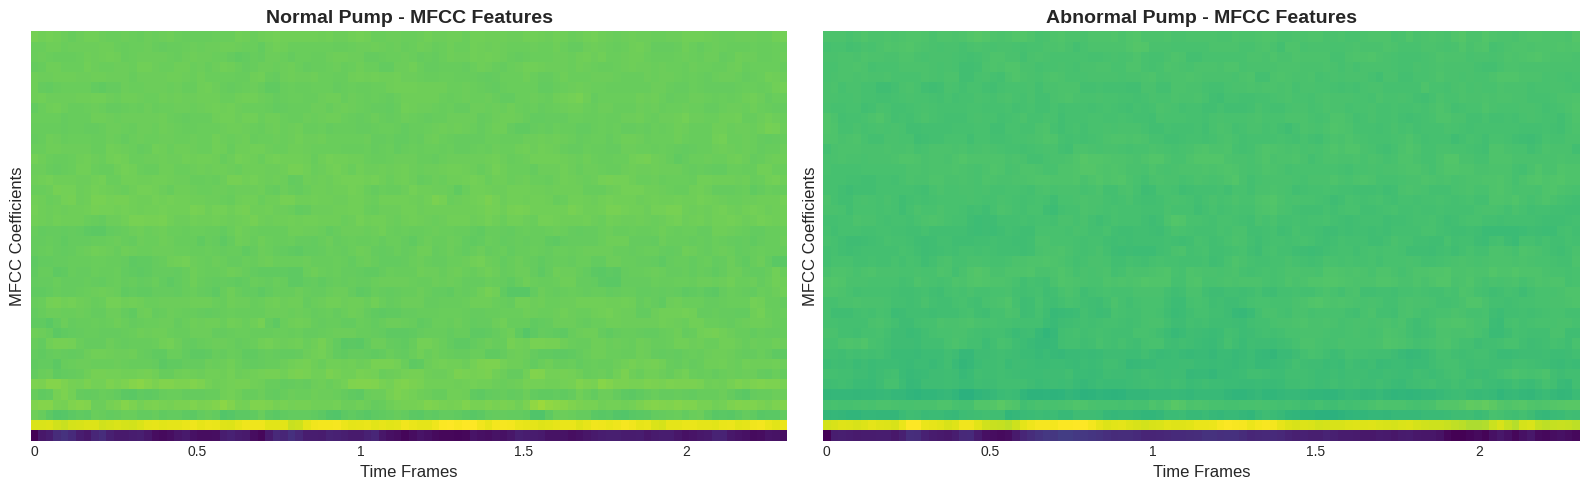

Visualization saved to /content/drive/My Drive/TractorCare/outputs/mfcc_comparison.png


In [26]:
# --------------------------------------------------------------
# Visualize Sample Features
# --------------------------------------------------------------
# Find indices of one normal and one abnormal sample from the loaded data
# Ensure indices are from the filtered data
normal_indices = [i for i, label in enumerate(y) if label == 0]
abnormal_indices = [i for i, label in enumerate(y) if label == 1]

if not normal_indices or not abnormal_indices:
    print("Could not find both normal and abnormal samples in the filtered data for visualization.")
else:
    normal_idx = normal_indices[0]
    abnormal_idx = abnormal_indices[0]

    # Create visualization
    fig, axes = plt.subplots(1, 2, figsize=(16, 5))

    # Normal sample
    librosa.display.specshow(X_mfcc[normal_idx].squeeze(), x_axis='time', ax=axes[0], cmap='viridis')
    axes[0].set_title('Normal Pump - MFCC Features', fontsize=14, fontweight='bold')
    axes[0].set_ylabel('MFCC Coefficients', fontsize=12)
    axes[0].set_xlabel('Time Frames', fontsize=12)

    # Abnormal sample
    librosa.display.specshow(X_mfcc[abnormal_idx].squeeze(), x_axis='time', ax=axes[1], cmap='viridis')
    axes[1].set_title('Abnormal Pump - MFCC Features', fontsize=14, fontweight='bold')
    axes[1].set_ylabel('MFCC Coefficients', fontsize=12)
    axes[1].set_xlabel('Time Frames', fontsize=12)

    plt.tight_layout()
    plt.savefig(config.output_dir / 'mfcc_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()

    print(f"Visualization saved to {config.output_dir / 'mfcc_comparison.png'}")

# Traditional ML Models

Split data for traditional models (using statistical features)

In [27]:

X_train_stats, X_test_stats, y_train_trad, y_test_trad = train_test_split(
    X_stats, y,
    test_size=config.test_size,
    random_state=config.random_state,
    stratify=y
)

# Scale features
scaler = StandardScaler()
X_train_stats_scaled = scaler.fit_transform(X_train_stats)
X_test_stats_scaled = scaler.transform(X_test_stats)


print("Traditional ML Data:")
print(f"{'='*60}")
print(f"Training set: {X_train_stats_scaled.shape}")
print(f"Test set: {X_test_stats_scaled.shape}")



Traditional ML Data:
Training set: (729, 360)
Test set: (183, 360)


# Deep Learning Models
Split data for CNN models (using raw MFCC features)

In [28]:
X_train_cnn, X_test_cnn, y_train_cnn, y_test_cnn = train_test_split(
    X_mfcc, y,
    test_size=config.test_size,
    random_state=config.random_state,
    stratify=y
)

# Reshape for CNN input (add channel dimension)
X_train_cnn = X_train_cnn[..., np.newaxis]
X_test_cnn = X_test_cnn[..., np.newaxis]

print("Deep Learning Data:")
print(f"{'='*60}")
print(f"Training set: {X_train_cnn.shape}")
print(f"Test set: {X_test_cnn.shape}")
print(f"Input shape for CNN: {X_train_cnn.shape[1:]}")


Deep Learning Data:
Training set: (729, 40, 100, 1)
Test set: (183, 40, 100, 1)
Input shape for CNN: (40, 100, 1)


# **Model Architectures**

Define functions to build different CNN architectures:
1. **Simple CNN**
2. **VGG-like CNN**
3. **ResNet-like CNN**

In [29]:
def build_simple_cnn(input_shape):
    """
    Build a simple CNN architecture.

    Architecture:
    - 2 Conv blocks (32, 64 filters)
    - MaxPooling after each conv block
    - Fully connected layers with dropout
    """
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),

        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),

        Flatten(),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model


def build_vgg_cnn(input_shape):
    """
    Build VGG-like CNN architecture.

    Architecture:
    - 3 VGG blocks (32, 64, 128 filters)
    - Each block has 2 conv layers
    - MaxPooling after each block
    """
    model = Sequential([
        # Block 1
        Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        Conv2D(32, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),

        # Block 2
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),

        # Block 3
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),

        # Classifier
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model


def resnet_block(x, filters, kernel_size=3, stride=1):
    """
    Residual block for ResNet-like architecture.

    Implements skip connection to allow gradient flow.
    """
    # Main path
    y = Conv2D(filters, kernel_size, strides=stride, padding='same', activation='relu')(x)
    y = BatchNormalization()(y)
    y = Conv2D(filters, kernel_size, strides=1, padding='same')(y)
    y = BatchNormalization()(y)

    # Skip connection
    if stride != 1 or x.shape[-1] != filters:
        x = Conv2D(filters, 1, strides=stride, padding='same')(x)
        x = BatchNormalization()(x)

    # Merge paths
    out = Add()([x, y])
    out = ReLU()(out)

    return out


def build_resnet_cnn(input_shape):
    """
    Build ResNet-like CNN architecture.

    Architecture:
    - Initial conv layer
    - 4 residual blocks
    - Global average pooling
    - Fully connected layers
    """
    inputs = Input(shape=input_shape)

    # Initial convolution
    x = Conv2D(32, 7, strides=2, padding='same', activation='relu')(inputs)
    x = BatchNormalization()(x)
    x = MaxPooling2D(3, strides=2, padding='same')(x)

    # Residual blocks
    x = resnet_block(x, 32)
    x = resnet_block(x, 32)
    x = resnet_block(x, 64, stride=2)
    x = resnet_block(x, 64)

    # Classifier
    x = GlobalAveragePooling2D()(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=inputs, outputs=outputs)

    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

print(" CNN model architectures defined")

 CNN model architectures defined


# **Training Pipeline**

Complete training pipeline with:
- Progress tracking
- Model evaluation
- Results storage

In [30]:
def compute_metrics(y_true, y_pred, y_pred_proba=None):
    """Compute comprehensive evaluation metrics."""
    metrics = {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred, zero_division=0),
        'recall': recall_score(y_true, y_pred, zero_division=0),
        'f1': f1_score(y_true, y_pred, zero_division=0),
        'confusion_matrix': confusion_matrix(y_true, y_pred).tolist()
    }

    # Add ROC-AUC if probabilities are provided
    if y_pred_proba is not None:
        try:
            metrics['roc_auc'] = roc_auc_score(y_true, y_pred_proba)
        except:
            metrics['roc_auc'] = None

    return metrics


def train_traditional_models(X_train, X_test, y_train, y_test, config):
    """Train all traditional ML models."""
    results = {}

    print(f"\n{'='*60}")
    print("TRAINING TRADITIONAL ML MODELS")
    print(f"{'='*60}\n")

    # 1. K-Nearest Neighbors
    print("Training K-Nearest Neighbors...")
    knn = KNeighborsClassifier(**config.knn_params)
    knn.fit(X_train, y_train)
    knn_pred = knn.predict(X_test)
    knn_proba = knn.predict_proba(X_test)[:, 1]

    results['KNN'] = {
        'model': knn,
        'predictions': knn_pred,
        'metrics': compute_metrics(y_test, knn_pred, knn_proba)
    }
    print(f"✓ KNN - Accuracy: {results['KNN']['metrics']['accuracy']:.4f}")

    # 2. Isolation Forest
    print("\nTraining Isolation Forest...")
    iso_forest = IsolationForest(**config.iso_forest_params)
    iso_forest.fit(X_train)
    iso_pred = iso_forest.predict(X_test)
    iso_pred = (iso_pred == -1).astype(int)  # Convert -1/1 to 0/1

    results['Isolation Forest'] = {
        'model': iso_forest,
        'predictions': iso_pred,
        'metrics': compute_metrics(y_test, iso_pred)
    }
    print(f"✓ Isolation Forest - Accuracy: {results['Isolation Forest']['metrics']['accuracy']:.4f}")

    # 3. Support Vector Machine
    print("\nTraining Support Vector Machine...")
    svm = SVC(**config.svm_params)
    svm.fit(X_train, y_train)
    svm_pred = svm.predict(X_test)
    svm_proba = svm.predict_proba(X_test)[:, 1]

    results['SVM'] = {
        'model': svm,
        'predictions': svm_pred,
        'metrics': compute_metrics(y_test, svm_pred, svm_proba)
    }
    print(f" SVM - Accuracy: {results['SVM']['metrics']['accuracy']:.4f}")

    return results


def train_cnn_models(X_train, X_test, y_train, y_test, config):
    """Train all CNN models."""
    results = {}
    input_shape = X_train.shape[1:]

    # Callbacks
    early_stop = EarlyStopping(
        monitor='val_loss',
        patience=config.early_stopping_patience,
        restore_best_weights=True,
        verbose=0
    )

    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-7,
        verbose=0
    )

    print(f"\n{'='*60}")
    print("TRAINING DEEP LEARNING MODELS")
    print(f"{'='*60}\n")

    # 1. Simple CNN
    print("Training Simple CNN...")
    cnn = build_simple_cnn(input_shape)
    history_cnn = cnn.fit(
        X_train, y_train,
        validation_split=config.validation_split,
        epochs=config.epochs,
        batch_size=config.batch_size,
        callbacks=[early_stop, reduce_lr],
        verbose=0
    )

    cnn_pred_proba = cnn.predict(X_test, verbose=0).flatten()
    cnn_pred = (cnn_pred_proba > 0.5).astype(int)

    results['CNN'] = {
        'model': cnn,
        'predictions': cnn_pred,
        'history': history_cnn.history, # Corrected: removed extra .history
        'metrics': compute_metrics(y_test, cnn_pred, cnn_pred_proba)
    }
    print(f" Simple CNN - Accuracy: {results['CNN']['metrics']['accuracy']:.4f}")

    # 2. VGG-like CNN
    print("\nTraining VGG-like CNN...")
    vgg = build_vgg_cnn(input_shape)
    history_vgg = vgg.fit(
        X_train, y_train,
        validation_split=config.validation_split,
        epochs=config.epochs,
        batch_size=config.batch_size,
        callbacks=[early_stop, reduce_lr],
        verbose=0
    )

    vgg_pred_proba = vgg.predict(X_test, verbose=0).flatten()
    vgg_pred = (vgg_pred_proba > 0.5).astype(int)

    results['VGG-like CNN'] = {
        'model': vgg,
        'predictions': vgg_pred,
        'history': history_vgg.history, # Corrected: removed extra .history
        'metrics': compute_metrics(y_test, vgg_pred, vgg_pred_proba)
    }
    print(f" VGG-like CNN - Accuracy: {results['VGG-like CNN']['metrics']['accuracy']:.4f}")

    # 3. ResNet-like CNN
    print("\nTraining ResNet-like CNN...")
    resnet = build_resnet_cnn(input_shape)
    history_resnet = resnet.fit(
        X_train, y_train,
        validation_split=config.validation_split,
        epochs=config.epochs,
        batch_size=config.batch_size,
        callbacks=[early_stop, reduce_lr],
        verbose=0
    )

    resnet_pred_proba = resnet.predict(X_test, verbose=0).flatten()
    resnet_pred = (resnet_pred_proba > 0.5).astype(int)

    results['ResNet-like CNN'] = {
        'model': resnet,
        'predictions': resnet_pred,
        'history': history_resnet.history, # Corrected: removed extra .history
        'metrics': compute_metrics(y_test, resnet_pred, resnet_pred_proba)
    }
    print(f" ResNet-like CNN - Accuracy: {results['ResNet-like CNN']['metrics']['accuracy']:.4f}")

    return results

print(" Training pipeline functions defined")

 Training pipeline functions defined


# **Train All Models**

Execute the complete training pipeline for both traditional ML and deep learning models.

In [31]:
# Train traditional ML models
trad_results = train_traditional_models(
    X_train_stats_scaled, X_test_stats_scaled,
    y_train_trad, y_test_trad,
    config
)

# Train CNN models
cnn_results = train_cnn_models(
    X_train_cnn, X_test_cnn,
    y_train_cnn, y_test_cnn,
    config
)

# Combine results
all_results = {**trad_results, **cnn_results}
print(" All models trained successfully!")



TRAINING TRADITIONAL ML MODELS

Training K-Nearest Neighbors...
✓ KNN - Accuracy: 0.9836

Training Isolation Forest...
✓ Isolation Forest - Accuracy: 0.5082

Training Support Vector Machine...
 SVM - Accuracy: 0.9891

TRAINING DEEP LEARNING MODELS

Training Simple CNN...


 Simple CNN - Accuracy: 0.9672

Training VGG-like CNN...
 VGG-like CNN - Accuracy: 0.9508

Training ResNet-like CNN...
 ResNet-like CNN - Accuracy: 0.9836
 All models trained successfully!


# Model Comparison & Selection

In [32]:
# Create comparison DataFrame
comparison_data = []

for model_name, result in all_results.items():
    metrics = result['metrics']
    comparison_data.append({
        'Algorithm': model_name,
        'Accuracy': metrics['accuracy'],
        'Precision': metrics['precision'],
        'Recall': metrics['recall'],
        'F1-Score': metrics['f1'],
        'ROC-AUC': metrics.get('roc_auc', 'N/A')
    })

results_df = pd.DataFrame(comparison_data)
results_df = results_df.sort_values('F1-Score', ascending=False).reset_index(drop=True)

# Display results
print(f"\n{'='*70}")
print("MODEL PERFORMANCE COMPARISON")
print(f"{'='*70}")
print(results_df.to_string(index=False))
print(f"{'='*70}\n")

# Save results
results_path = config.output_dir / 'model_comparison_results.csv'
results_df.to_csv(results_path, index=False)
print(f" Results saved to {results_path}")

# Identify best models
best_overall = results_df.iloc[0]['Algorithm']
best_traditional = results_df[~results_df['Algorithm'].str.contains('CNN')].iloc[0]['Algorithm']
best_cnn = results_df[results_df['Algorithm'].str.contains('CNN')].iloc[0]['Algorithm']




MODEL PERFORMANCE COMPARISON
       Algorithm  Accuracy  Precision   Recall  F1-Score   ROC-AUC
             SVM  0.989071   0.989011 0.989011  0.989011  0.998686
             KNN  0.983607   0.988889 0.978022  0.983425  0.987637
 ResNet-like CNN  0.983607   1.000000 0.967033  0.983240       1.0
             CNN  0.967213   0.967033 0.967033  0.967033  0.992953
    VGG-like CNN  0.950820   0.955556 0.945055  0.950276  0.987219
Isolation Forest  0.508197   1.000000 0.010989  0.021739       N/A

 Results saved to /content/drive/My Drive/TractorCare/outputs/model_comparison_results.csv


# Save All Models

In [34]:
# --------------------------------------------------------------
# 9. Save All Models & Scaler
# --------------------------------------------------------------
models_dir = config.output_dir / 'models'
models_dir.mkdir(exist_ok=True)

# Save scaler
joblib.dump(scaler, models_dir / 'scaler.pkl')

# Save all models
for name, res in all_results.items():
    if name in ['KNN', 'Isolation Forest', 'SVM']:
        joblib.dump(res['model'], models_dir / f"{name.lower().replace(' ', '_')}.pkl")
    else:
        # Sanitize the name for saving
        sanitized_name = name.lower().replace(' ', '_').replace('-', '_')
        res['model'].save(models_dir / f"{sanitized_name}.h5")

# Save best model (using best_overall from the previous cell)
best_model_to_save_name = best_overall
best_model = all_results[best_model_to_save_name]['model']

# Sanitize the name for saving the best model file
sanitized_best_model_name = best_model_to_save_name.lower().replace(' ', '_').replace('-', '_')

if 'CNN' in best_model_to_save_name:
    best_model.save(models_dir / f'{sanitized_best_model_name}_best_model.h5')
else:
    joblib.dump(best_model, models_dir / f'{sanitized_best_model_name}_best_model.pkl')

# Convert Path objects in config to strings before saving
config_to_save = vars(config).copy()
config_to_save['base_path'] = str(config_to_save['base_path'])
config_to_save['output_dir'] = str(config_to_save['output_dir'])

config_path = config.output_dir / 'config.json'
with open(config_path, 'w') as f:
    json.dump(config_to_save, f, indent=4)
print(f"Config saved: {config_path}")


print("\nAll models and config saved")

Config saved: /content/drive/My Drive/TractorCare/outputs/config.json

All models and config saved


# **PART 2: Transfer Learning & Edge Deployment**

**Objective:**  
Apply **best model (ResNet-like CNN)** to real **tractor sounds** and simulate **edge AI deployment**.

**Steps:**  
1. Import & convert tractor audio  
2. Transfer learning from MIMII → Tractor  
3. Per-tractor baseline (Reality AI style)  
4. Offline-first detection with adaptive learning  
5. Final field test simulation (Rwanda)

**Why Transfer Learning?**  
- Limited labeled tractor data  
- ResNet already learned industrial sound patterns  
- Fine-tune with low LR → fast, effective

In [35]:
# --------------------------------------------------------------
# 1. Convert Tractor Audio to 16kHz Mono WAV
# --------------------------------------------------------------
!pip install -q pydub

tractor_base = config.base_path.parent / "tractor"
normal_dir = tractor_base / "normal"
abnormal_dir = tractor_base / "abnormal"

def convert_folder(folder):
    wavs = []
    for src in tqdm(folder.glob("*.*"), desc=f"Converting {folder.name}"):
        dst = src.with_suffix(".wav")
        if not dst.exists():
            audio = AudioSegment.from_file(src)
            audio = audio.set_channels(1).set_frame_rate(config.sample_rate)
            audio.export(dst, format="wav")
        wavs.append(str(dst))
    return wavs

tractor_normal_files = convert_folder(normal_dir)
tractor_abnormal_files = convert_folder(abnormal_dir)

print(f"\nTractor Normal   : {len(tractor_normal_files)}")
print(f"Tractor Abnormal : {len(tractor_abnormal_files)}")

Converting normal: 11it [00:00, 34.72it/s]
Converting abnormal: 12it [00:00, 38.89it/s]


Tractor Normal   : 11
Tractor Abnormal : 12


In [62]:
# --------------------------------------------------------------
# 2. Transfer Learning: MIMII ResNet → Tractor
# --------------------------------------------------------------
# Load best ResNet
import sklearn
resnet_path = models_dir / 'resnet_like_cnn.h5'
pretrained = tf.keras.models.load_model(resnet_path)

# Freeze early layers (unfreeze last 5 layers instead of 3)
for layer in pretrained.layers[:-5]:
    layer.trainable = False
for layer in pretrained.layers[-5:]:
    layer.trainable = True

# Build transfer model using Functional API
inputs = Input(shape=pretrained.input_shape[1:], name='input_transfer')
x = pretrained(inputs) # Connect the output of the pretrained model
x = Dense(128, activation='relu', name='transfer_dense1')(x)
x = Dropout(0.3, name='transfer_dropout')(x)
outputs = Dense(1, activation='sigmoid', name='transfer_output')(x)

transfer_model = Model(inputs=inputs, outputs=outputs)

transfer_model.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])

# Prepare tractor data
# Use resample directly as it's imported from sklearn.utils
tractor_bal = resample(tractor_normal_files, n_samples=len(tractor_abnormal_files), random_state=42)
tractor_files = tractor_bal + tractor_abnormal_files
tractor_labels = [0]*len(tractor_bal) + [1]*len(tractor_abnormal_files)

X_tractor = [np.expand_dims(extract_mfcc_full(f, config), -1) for f in tqdm(tractor_files, desc="Tractor MFCC")]
X_tractor = np.array([x for x in X_tractor if x is not None])
y_tractor = tractor_labels[:len(X_tractor)]

X_tr, X_te, y_tr, y_te = train_test_split(X_tractor, y_tractor, test_size=0.2, stratify=y_tractor, random_state=42)

# Convert y_tr to a NumPy array
y_tr = np.array(y_tr)

# Train
transfer_model.fit(X_tr, y_tr,
                   validation_split=0.2,
                   epochs=12,
                   batch_size=16,
                   callbacks=[EarlyStopping(patience=5, restore_best_weights=True)],
                   verbose=1)

# Save
transfer_path = models_dir / 'tractor_resnet_transfer.h5'
transfer_model.save(transfer_path)
print(f"Transfer model saved: {transfer_path}")

TypeError: resample() got an unexpected keyword argument 'n_samples'

In [ ]:
# Save
transfer_path = models_dir / 'tractor_resnet_transfer.h5'
transfer_model.save(transfer_path)
print(f"Transfer model saved: {transfer_path}")